In [19]:
import pandas as pd
import numpy as np
from scipy.signal import welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
FS = 256  # sampling rate
WINDOW = 128
STEP = 64

BANDS = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}


In [ ]:
df = pd.read_csv("../../data/combined_eeg_dataset.csv")  # adjust path as needed
eeg_cols = df.select_dtypes(include=np.number).columns.tolist()
label_col = "Class"
patient_col = "ID"


In [21]:
def compute_band_powers(signal, fs=FS):
    freqs, psd = welch(signal, fs=fs, nperseg=fs)
    band_powers = {}
    for band, (low, high) in BANDS.items():
        idx = np.logical_and(freqs >= low, freqs <= high)
        band_powers[band] = np.mean(psd[idx])
    return band_powers


In [22]:
features, labels, patient_ids = [], [], []

for pid in df[patient_col].unique():
    patient_data = df[df[patient_col] == pid]
    if len(patient_data) < WINDOW:
        continue

    label = patient_data[label_col].iloc[0]
    signal = patient_data[eeg_cols].values
    segment_features = []

    for i in range(0, len(signal) - WINDOW + 1, STEP):
        segment = signal[i:i + WINDOW]
        band_matrix = []
        for ch in range(segment.shape[1]):
            bp = compute_band_powers(segment[:, ch])
            band_matrix.append([bp[b] for b in BANDS])
        segment_features.append(np.array(band_matrix))

    segment_features = np.array(segment_features)  # shape: (windows, channels, bands)
    if segment_features.size == 0:
        continue

    # Aggregate features
    mean_feat = segment_features.mean(axis=0).flatten()
    std_feat = segment_features.std(axis=0).flatten()

    # Band ratio features
    band_idx = list(BANDS)
    theta = segment_features[:, :, band_idx.index("theta")].mean()
    beta = segment_features[:, :, band_idx.index("beta")].mean()
    delta = segment_features[:, :, band_idx.index("delta")].mean()
    alpha = segment_features[:, :, band_idx.index("alpha")].mean()

    ratios = [
        theta / (beta + 1e-6),
        delta / (theta + 1e-6),
        alpha / (beta + 1e-6),
        (theta + delta) / (alpha + beta + 1e-6)
    ]

    final_vector = np.concatenate([mean_feat, std_feat, ratios])
    features.append(final_vector)
    labels.append(label)
    patient_ids.append(pid)


c:\Users\Tenodese\.conda\envs\adha_eeg_env_2\lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Tenodese\.conda\envs\adha_eeg_env_2\lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Tenodese\.conda\envs\adha_eeg_env_2\lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Tenodese\.conda\envs\adha_eeg_env_2\lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg

In [23]:
X = np.array(features)
y = LabelEncoder().fit_transform(labels)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


In [24]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.75      0.75      0.75        12

    accuracy                           0.76        25
   macro avg       0.76      0.76      0.76        25
weighted avg       0.76      0.76      0.76        25

ROC AUC: 0.8333333333333333


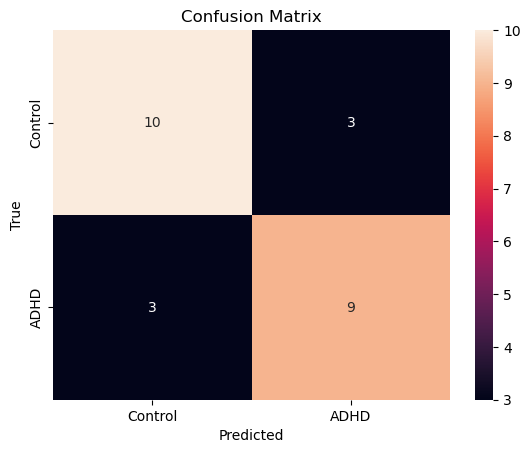

In [25]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Control', 'ADHD'], yticklabels=['Control', 'ADHD'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


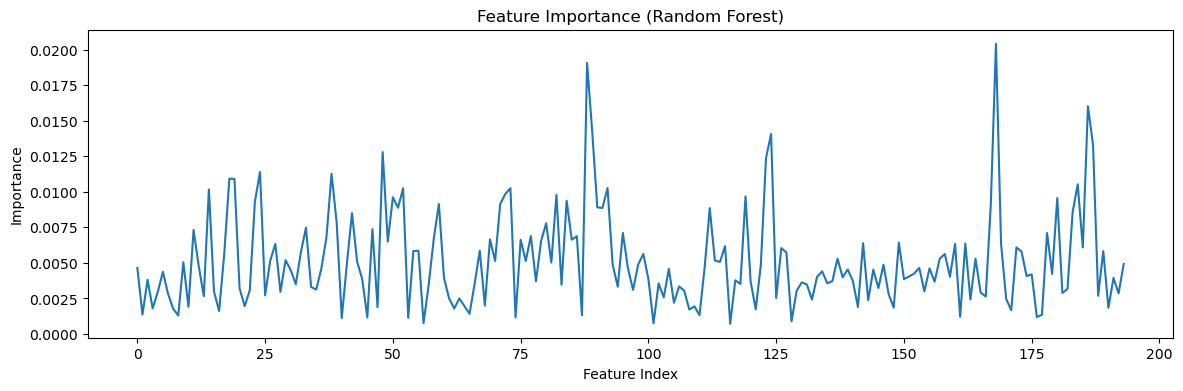

In [26]:
importances = clf.feature_importances_
plt.figure(figsize=(14, 4))
plt.plot(importances)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()
